In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
import shap
import joblib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load dataset
file_path = '/content/drive/MyDrive/Datasets/Churn_Modelling.csv'
data = pd.read_csv(file_path)

In [5]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10000,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


In [6]:
# Preprocessing and Feature Engineering
data = data.drop_duplicates()
data['Gender'] = data['Gender'].map({'Female': 0, 'Male': 1})
data = pd.get_dummies(data, columns=["Geography"], drop_first=True)
data.drop(columns=["RowNumber", "CustomerId", "Surname"], inplace=True)
data.fillna(0, inplace=True)

<ipython-input-6-3bc7c72a99ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Gender'] = data['Gender'].map({'Female': 0, 'Male': 1})


In [7]:
# Feature Engineering
data["Revenue_Proxy"] = data["Balance"] * data["NumOfProducts"]
data["Engagement_Score"] = data["IsActiveMember"] + data["HasCrCard"] + data["NumOfProducts"]
data["Risk_Indicator"] = data["CreditScore"] / data["Age"]
data["Spending_Potential"] = data["EstimatedSalary"] * data["NumOfProducts"]
data["Tenure_Weighted_Balance"] = data["Balance"] * data["Tenure"]
data["HVC"] = (data["Balance"] > data["Balance"].median()).astype(int)

In [8]:
data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Revenue_Proxy,Engagement_Score,Risk_Indicator,Spending_Potential,Tenure_Weighted_Balance,HVC
0,619,0,42.0,2,0.00,1,1.0,1.0,101348.88,1,False,False,0.00,3.0,14.738095,101348.88,0.00,0
1,608,0,41.0,1,83807.86,1,0.0,1.0,112542.58,0,False,True,83807.86,2.0,14.829268,112542.58,83807.86,0
2,502,0,42.0,8,159660.80,3,1.0,0.0,113931.57,1,False,False,478982.40,4.0,11.952381,341794.71,1277286.40,1
3,699,0,39.0,1,0.00,2,0.0,0.0,93826.63,0,False,False,0.00,2.0,17.923077,187653.26,0.00,0
4,850,0,43.0,2,125510.82,1,0.0,1.0,79084.10,0,False,True,125510.82,2.0,19.767442,79084.10,251021.64,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39.0,5,0.00,2,1.0,0.0,96270.64,0,False,False,0.00,3.0,19.769231,192541.28,0.00,0
9996,516,1,35.0,10,57369.61,1,1.0,1.0,101699.77,0,False,False,57369.61,3.0,14.742857,101699.77,573696.10,0
9997,709,0,36.0,7,0.00,1,0.0,1.0,42085.58,1,False,False,0.00,2.0,19.694444,42085.58,0.00,0
9998,772,1,42.0,3,75075.31,2,1.0,0.0,92888.52,1,True,False,150150.62,3.0,18.380952,185777.04,225225.93,0


In [12]:
# Drop rows with any infinite values
data = data[~np.isinf(data).any(axis=1)]

In [13]:
# CLV Prediction Features and Target
X_clv = data[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard",
              "IsActiveMember", "EstimatedSalary", "Geography_Germany", "Geography_Spain",
              "Engagement_Score", "Risk_Indicator", "Spending_Potential", "Tenure_Weighted_Balance", "HVC"]]
y_clv = data["Revenue_Proxy"]

# Churn Prediction Features and Target
X_churn = X_clv.copy()
y_churn = data["Exited"]

In [14]:
# Train-Test Split for CLV and Churn Prediction
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.25, random_state=42)
X_train_churn, X_test_churn, y_train_churn, y_test_churn = train_test_split(X_churn, y_churn, test_size=0.25, random_state=42)

In [15]:
# Feature Scaling
scaler = StandardScaler()
X_train_clv_scaled = scaler.fit_transform(X_train_clv)
X_test_clv_scaled = scaler.transform(X_test_clv)
X_train_churn_scaled = scaler.fit_transform(X_train_churn)
X_test_churn_scaled = scaler.transform(X_test_churn)

In [16]:
# Handle Class Imbalance for Churn Prediction using SMOTE
smote = SMOTE(random_state=42)
X_train_churn_balanced, y_train_churn_balanced = smote.fit_resample(X_train_churn_scaled, y_train_churn)

In [17]:
# CLV Model Training and Evaluation
clv_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

In [18]:
rmse_scores = []
r2_scores = []

for name, model in clv_models.items():
    model.fit(X_train_clv_scaled, y_train_clv)
    y_pred = model.predict(X_test_clv_scaled)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test_clv, y_pred)))
    r2_scores.append(r2_score(y_test_clv, y_pred))

<ipython-input-19-edff38d0d639>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models_list, y=rmse_scores, palette='viridis')
<ipython-input-19-edff38d0d639>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models_list, y=r2_scores, palette='viridis')


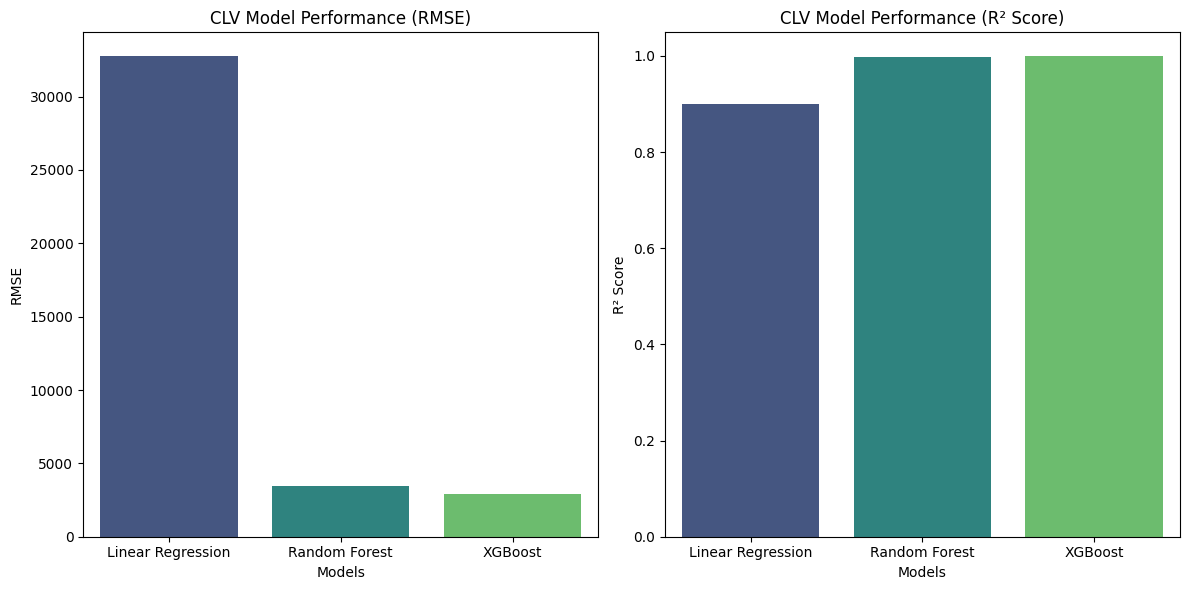

In [19]:
# Visualization for CLV Model Performance
models_list = list(clv_models.keys())
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=models_list, y=rmse_scores, palette='viridis')
plt.title('CLV Model Performance (RMSE)')
plt.ylabel('RMSE')
plt.xlabel('Models')

plt.subplot(1, 2, 2)
sns.barplot(x=models_list, y=r2_scores, palette='viridis')
plt.title('CLV Model Performance (R² Score)')
plt.ylabel('R² Score')
plt.xlabel('Models')

plt.tight_layout()
plt.show()

<ipython-input-26-c0d690fd1904>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_clv, y=X_clv.columns, palette='viridis')


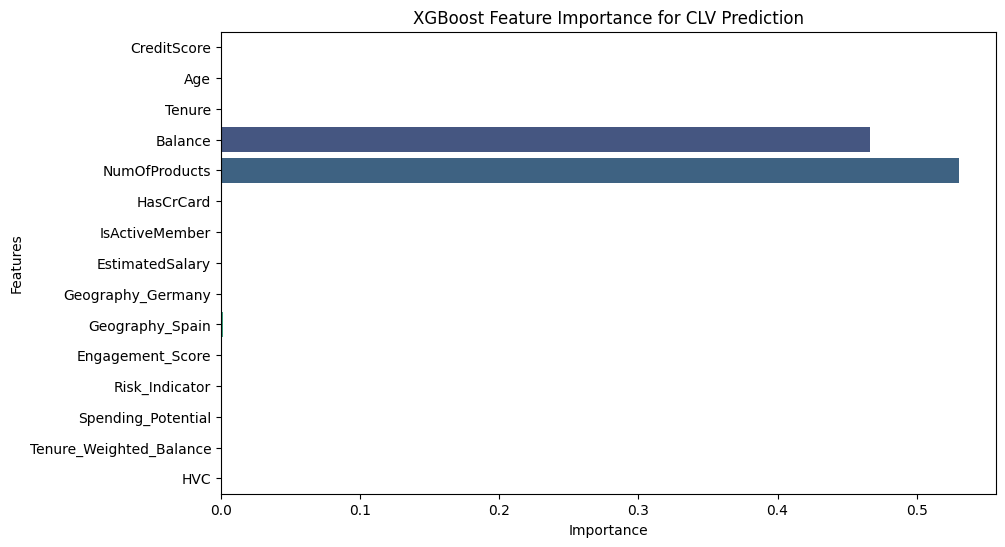

In [26]:
# Get feature importance
xgb_model_clv = XGBRegressor(random_state=42)
xgb_model_clv.fit(X_train_clv_scaled, y_train_clv)
feature_importance_clv = xgb_model_clv.feature_importances_

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_clv, y=X_clv.columns, palette='viridis')
plt.title('XGBoost Feature Importance for CLV Prediction')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [21]:
# Churn Model Training and Evaluation
churn_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

In [22]:
accuracy_scores = []
f1_scores = []

for name, model in churn_models.items():
    model.fit(X_train_churn_balanced, y_train_churn_balanced)
    y_pred = model.predict(X_test_churn_scaled)
    accuracy_scores.append(accuracy_score(y_test_churn, y_pred))
    f1_scores.append(f1_score(y_test_churn, y_pred))

<ipython-input-23-6068bdcb418a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models_list_churn, y=accuracy_scores, palette='coolwarm')
<ipython-input-23-6068bdcb418a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models_list_churn, y=f1_scores, palette='coolwarm')


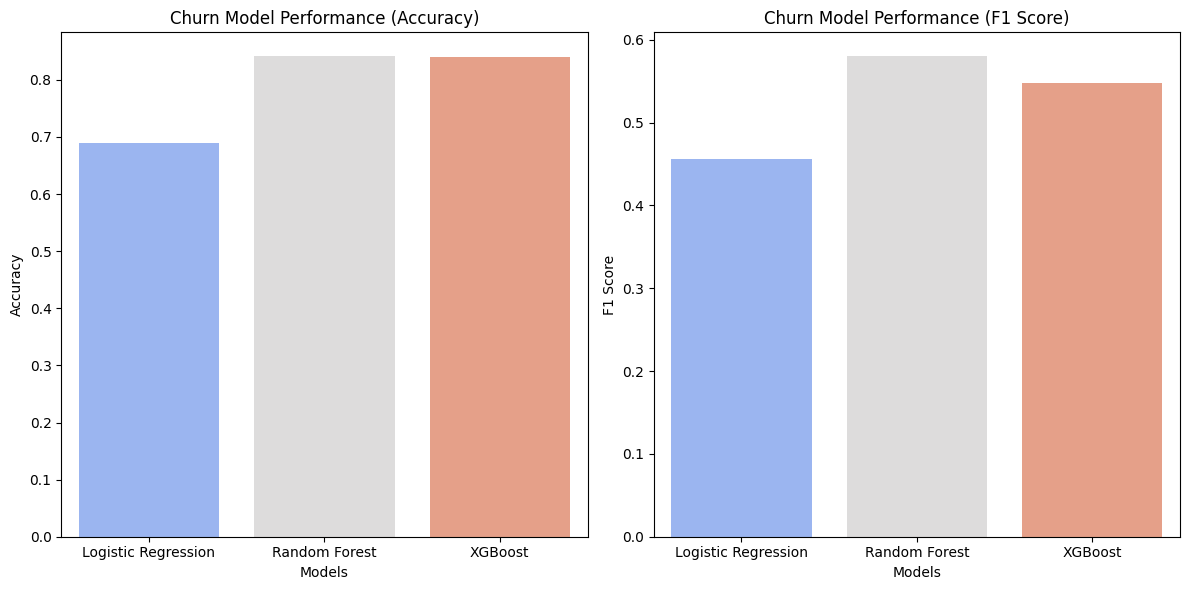

In [23]:
# Visualization for Churn Model Performance
models_list_churn = list(churn_models.keys())
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=models_list_churn, y=accuracy_scores, palette='coolwarm')
plt.title('Churn Model Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Models')

plt.subplot(1, 2, 2)
sns.barplot(x=models_list_churn, y=f1_scores, palette='coolwarm')
plt.title('Churn Model Performance (F1 Score)')
plt.ylabel('F1 Score')
plt.xlabel('Models')

plt.tight_layout()
plt.show()

<ipython-input-24-a4a81d9039aa>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_churn, y=X_churn.columns, palette='coolwarm')


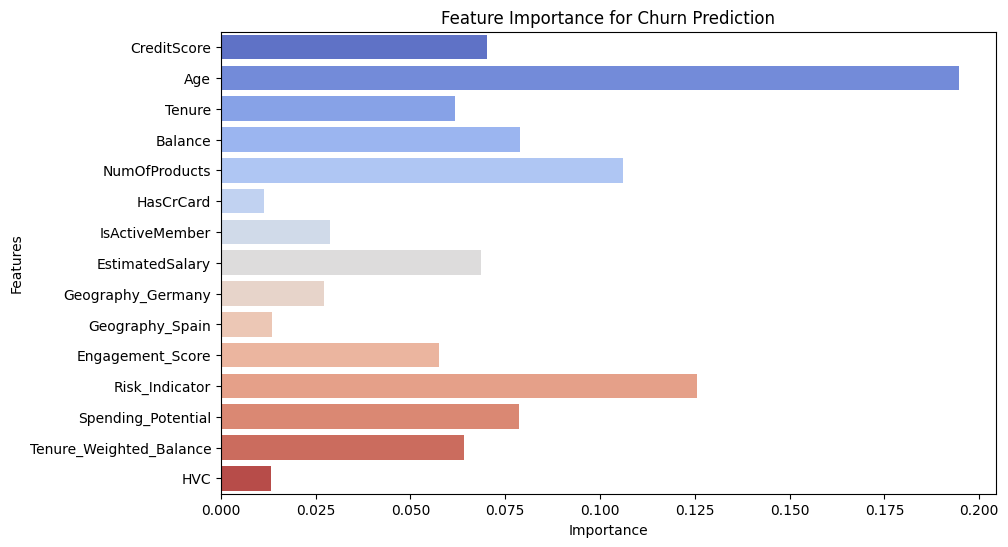

In [24]:
# Feature Importance for Churn (Using Random Forest as an example)
rf_model_churn = RandomForestClassifier(random_state=42)
rf_model_churn.fit(X_train_churn_balanced, y_train_churn_balanced)
feature_importance_churn = rf_model_churn.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_churn, y=X_churn.columns, palette='coolwarm')
plt.title('Feature Importance for Churn Prediction')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [31]:
# Determine best models
best_clv_model_name = models_list[np.argmin(rmse_scores)]
best_churn_model_name = models_list_churn[np.argmax(f1_scores)]

best_clv_model = clv_models[best_clv_model_name]
best_churn_model = churn_models[best_churn_model_name]


print(f"Best clv model {best_clv_model_name}")
print(f"Best churn model {best_churn_model_name}")

Best clv model XGBoost
Best churn model Random Forest


In [32]:
import joblib
import tarfile
import os

# Define save directory
save_dir = '/content/drive/MyDrive/Datasets/'

# Save the best CLV model
clv_model_path = os.path.join(save_dir, "clv_model.pkl")
joblib.dump(best_clv_model, clv_model_path)

clv_tar_path = os.path.join(save_dir, "clv_model.tar.gz")
with tarfile.open(clv_tar_path, "w:gz") as tar:
    tar.add(clv_model_path, arcname="clv_model.pkl")

# Save the best Churn model
churn_model_path = os.path.join(save_dir, "churn_model.pkl")
joblib.dump(best_churn_model, churn_model_path)

churn_tar_path = os.path.join(save_dir, "churn_model.tar.gz")
with tarfile.open(churn_tar_path, "w:gz") as tar:
    tar.add(churn_model_path, arcname="churn_model.pkl")

print(f"Models saved at:\n{clv_tar_path}\n{churn_tar_path}")

Models saved at:
/content/drive/MyDrive/Datasets/clv_model.tar.gz
/content/drive/MyDrive/Datasets/churn_model.tar.gz
